Miłosz Błachowiak

**Lab 5 - Using link functions to create generalized linear models**

In [323]:
from cmdstanpy import CmdStanModel
from cmdstanpy import install_cmdstan
 
install_cmdstan()

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
CmdStan version 2.31.0 already installed


In [324]:
df = pd.read_csv('Airline_data.csv')
df["Miles flown [100 bln miles]"] = df["Miles flown [100 mln miles]"] / 1000 # scaling
df

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles],Miles flown [100 bln miles]
0,1976,24,734,3863.0,3.863
1,1977,25,516,4300.0,4.300
2,1978,31,754,5027.0,5.027
3,1979,31,877,5481.0,5.481
4,1980,22,814,5814.0,5.814
5,1981,21,362,6033.0,6.033
6,1982,26,764,5877.0,5.877
7,1983,20,809,6223.0,6.223
8,1984,16,223,7433.0,7.433
9,1985,22,1066,7107.0,7.107


In [325]:
df.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles],Miles flown [100 bln miles]
count,10.00000,10.000000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000,5.715800
std,3.02765,4.709329,252.389228,1117.767795,1.117768
min,1976.00000,16.000000,223.000000,3863.000000,3.863000
25%,1978.25000,21.250000,570.500000,5140.500000,5.140500
50%,1980.50000,23.000000,759.000000,5845.500000,5.845500
75%,1982.75000,25.750000,812.750000,6175.500000,6.175500
max,1985.00000,31.000000,1066.000000,7433.000000,7.433000


**Prior predictive analysis**

In [326]:
model_ppc=CmdStanModel(stan_file='ppc_1.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/Data_Analytics_LAB/Lab5/ppc_1.stan to exe file /home/Data_Analytics_LAB/Lab5/ppc_1
INFO:cmdstanpy:compiled model executable: /home/Data_Analytics_LAB/Lab5/ppc_1
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Data_Analytics_LAB/Lab5/ppc_1.hpp /home/Data_Analytics_LAB/Lab5/ppc_1.stan
Warning in '/home/Data_Analytics_LAB/Lab5/ppc_1.stan', line 4, column 44: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/home/Data_Analytics_LAB/Lab5/ppc_1.stan', line 8, column 35: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attribut


INFO:cmdstanpy:CmdStan done processing.


In [327]:
dataframe = sim.draws_pd()
dataframe.describe()

,lp__,accept_stat__,alpha,theta,n_i,lambda,y_i
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,2.476613,0.099364,4.946666,32.854617,33.005000
std,0.0,0.0,1.003448,0.020779,1.091878,42.802105,43.378966
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,1.763373,0.087244,4.260045,9.676728,10.000000
50%,0.0,0.0,2.481060,0.099239,4.957095,19.494350,19.000000
75%,0.0,0.0,3.164277,0.112385,5.652473,39.129125,39.250000
max,0.0,0.0,5.539480,0.163756,7.673040,467.141000,476.000000


In [328]:
dataframe.head()

,lp__,accept_stat__,alpha,theta,n_i,lambda,y_i
0,0.0,0.0,5.20817,0.115544,3.72773,281.1490,295.0
1,0.0,0.0,0.00000,0.000000,0.00000,0.0000,0.0
2,0.0,0.0,3.24349,0.113119,5.23010,46.2987,39.0
3,0.0,0.0,3.09894,0.099559,6.31205,41.5694,28.0
4,0.0,0.0,2.15787,0.093777,6.66065,16.1593,18.0


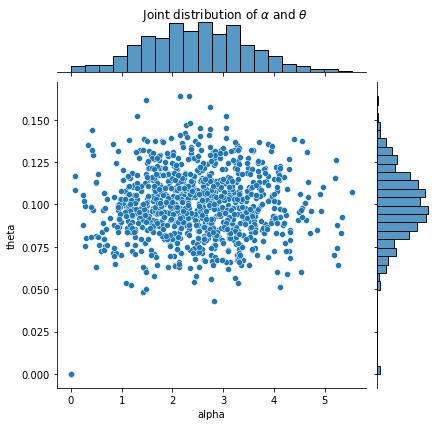

In [329]:
sns.jointplot(dataframe, x='alpha', y='theta')
plt.suptitle("Joint distribution of $\\alpha$ and $\\theta$")
plt.subplots_adjust(top=0.95)

Text(0.5, 1.0, 'Histogram of $y$ (number of accidents)')

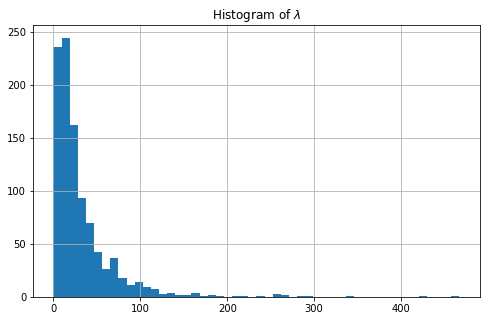

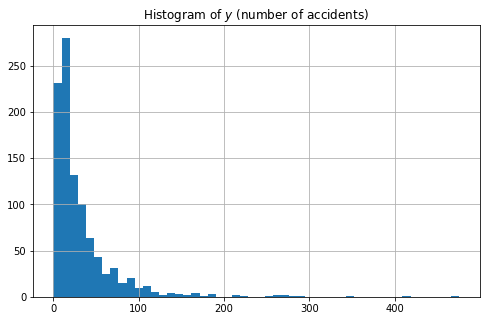

In [330]:
plt.figure(figsize=(8, 5))
dataframe['lambda'].hist(bins=50)
plt.title("Histogram of $\\lambda$")

plt.figure(figsize=(8, 5))
dataframe['y_i'].hist(bins=50)
plt.title("Histogram of $y$ (number of accidents)")

**Posterior predictive distribution with single intercept $\alpha$**

In [331]:
fit_model=CmdStanModel(stan_file='fit_1.stan')

sim=fit_model.sample(data={'N': len(df), 'n': df['Miles flown [100 bln miles]'].values, 'y': df['Fatal accidents'].values}, seed=29042020)

INFO:cmdstanpy:compiling stan file /home/Data_Analytics_LAB/Lab5/fit_1.stan to exe file /home/Data_Analytics_LAB/Lab5/fit_1
INFO:cmdstanpy:compiled model executable: /home/Data_Analytics_LAB/Lab5/fit_1
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Data_Analytics_LAB/Lab5/fit_1.hpp /home/Data_Analytics_LAB/Lab5/fit_1.stan
Warning in '/home/Data_Analytics_LAB/Lab5/fit_1.stan', line 3, column 26: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/home/Data_Analytics_LAB/Lab5/fit_1.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Data_Analytics_LAB/Lab5/fit_1.stan', line 4, col


INFO:cmdstanpy:CmdStan done processing.


In [332]:
dataframe = sim.draws_pd()
dataframe.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],...,y_p[1],y_p[2],y_p[3],y_p[4],y_p[5],y_p[6],y_p[7],y_p[8],y_p[9],y_p[10]
0,512.774,1.000000,0.372215,2.0,3.0,0.0,-511.471,2.67720,0.086826,20.3403,...,15.0,14.0,20.0,34.0,33.0,37.0,30.0,31.0,29.0,28.0
1,512.529,0.975883,0.372215,2.0,7.0,0.0,-511.517,2.76032,0.067456,20.5097,...,17.0,23.0,18.0,18.0,19.0,17.0,26.0,20.0,23.0,24.0
2,512.393,0.999180,0.372215,2.0,7.0,0.0,-512.289,2.82108,0.065949,21.6682,...,19.0,25.0,17.0,23.0,28.0,34.0,23.0,33.0,22.0,29.0
3,509.581,0.576660,0.372215,2.0,7.0,0.0,-507.432,2.60539,0.069282,17.6905,...,22.0,22.0,19.0,19.0,9.0,16.0,25.0,26.0,26.0,24.0
4,512.249,0.994232,0.372215,2.0,7.0,0.0,-509.413,2.61481,0.084023,18.9044,...,27.0,17.0,21.0,27.0,18.0,26.0,21.0,19.0,27.0,23.0


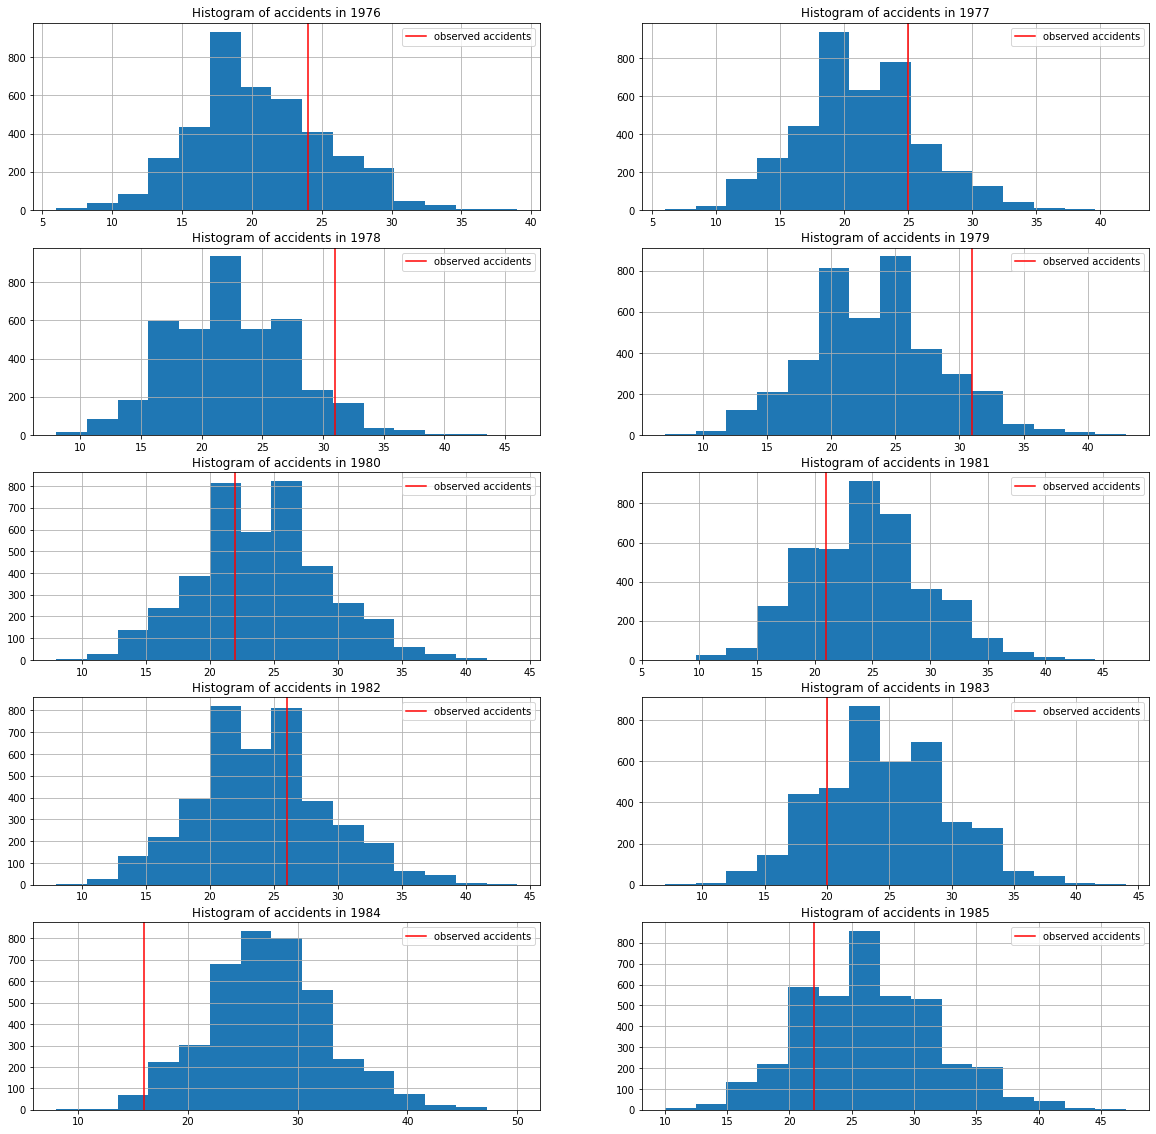

In [333]:
years = df['Year'].values
fig, axs = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize=(20, 20))
axs = np.reshape(axs, -1)

for i, ax in enumerate(axs):
    ax.hist(dataframe[f'y_p[{i+1}]'], bins=15)
    ax.axvline(x=df['Fatal accidents'].values[i], color='r', label="observed accidents")
    ax.set_title(f"Histogram of accidents in {years[i]}")
    ax.legend()
    ax.grid()

When we use a common intercept value $\alpha$ the quality of the model varies from year to year.

**Posterior predictive distribution with individual $\alpha_i$ for each year**

In [334]:
fit_model=CmdStanModel(stan_file='fit_2.stan')

sim=fit_model.sample(data={'N': len(df), 'n': df['Miles flown [100 bln miles]'].values, 'y': df['Fatal accidents'].values}, seed=29042020)

INFO:cmdstanpy:compiling stan file /home/Data_Analytics_LAB/Lab5/fit_2.stan to exe file /home/Data_Analytics_LAB/Lab5/fit_2
INFO:cmdstanpy:compiled model executable: /home/Data_Analytics_LAB/Lab5/fit_2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Data_Analytics_LAB/Lab5/fit_2.hpp /home/Data_Analytics_LAB/Lab5/fit_2.stan
Warning in '/home/Data_Analytics_LAB/Lab5/fit_2.stan', line 3, column 26: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/home/Data_Analytics_LAB/Lab5/fit_2.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Data_Analytics_LAB/Lab5/fit_2.stan', line 4, col


INFO:cmdstanpy:CmdStan done processing.


In [335]:
dataframe = sim.draws_pd()
dataframe.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,y_p[1],y_p[2],y_p[3],y_p[4],y_p[5],y_p[6],y_p[7],y_p[8],y_p[9],y_p[10]
0,511.023,0.989056,0.47651,3.0,7.0,0.0,-506.823,3.20188,3.13615,3.33994,...,27.0,37.0,39.0,36.0,21.0,28.0,32.0,13.0,20.0,15.0
1,515.012,1.000000,0.47651,3.0,7.0,0.0,-508.430,2.66925,2.92456,2.81201,...,16.0,28.0,15.0,33.0,14.0,28.0,22.0,16.0,15.0,31.0
2,514.825,0.954090,0.47651,3.0,7.0,0.0,-508.033,2.82274,2.71819,2.90387,...,23.0,20.0,37.0,40.0,21.0,21.0,33.0,19.0,18.0,16.0
3,517.310,0.936854,0.47651,3.0,7.0,0.0,-510.330,2.71195,2.73933,2.94213,...,13.0,30.0,28.0,37.0,20.0,16.0,18.0,13.0,24.0,25.0
4,517.048,0.784196,0.47651,3.0,7.0,0.0,-511.087,2.62311,2.69312,2.88389,...,21.0,20.0,26.0,26.0,27.0,14.0,32.0,14.0,22.0,10.0


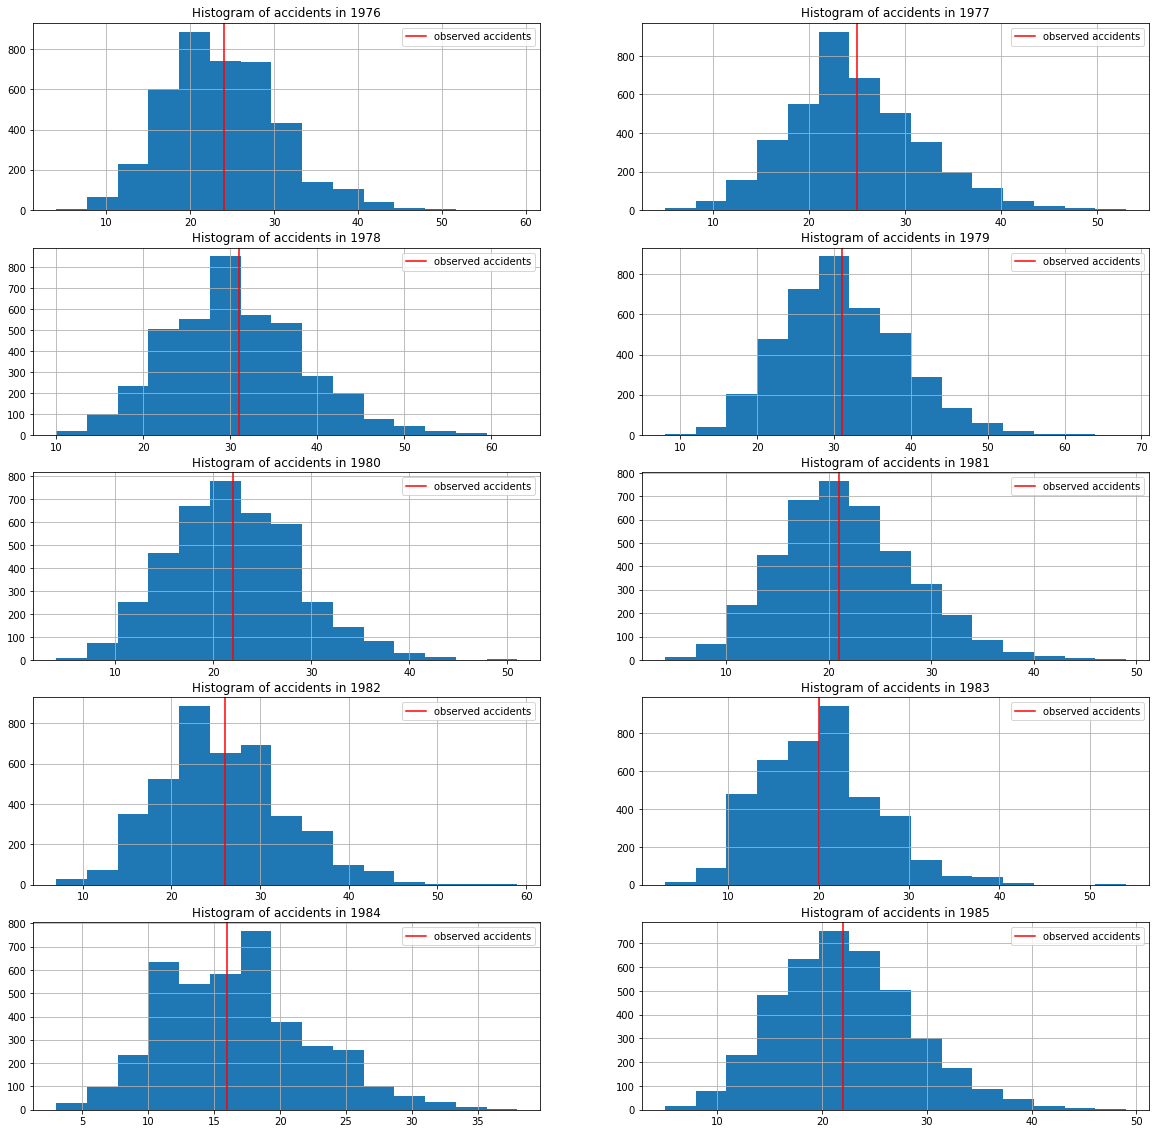

In [336]:
years = df['Year'].values
fig, axs = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize=(20, 20))
axs = np.reshape(axs, -1)

for i, ax in enumerate(axs):
    ax.hist(dataframe[f'y_p[{i+1}]'], bins=15)
    ax.axvline(x=df['Fatal accidents'].values[i], color='r', label="observed accidents")
    ax.set_title(f"Histogram of accidents in {years[i]}")
    ax.legend()
    ax.grid()

After introducing individual intercepts $\alpha_i$ for each year the results improved significantly - the model fits the observed data much better.